In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from script import training_data, test_data
from skimage.transform import resize
import tensorflow as tf

In [2]:
d1 = '.\\data\\lunar\\training\\data\\S12_GradeA'
d2 = '.\\data\\lunar\\training\\catalogs'
d3 = '.\\data\\lunar\\test\\data\\S16_GradeA'

xtrn, ytrn = training_data(d1, d2)
xtst = test_data(d3)

In [3]:
# Suponiendo que xtrn y xtst son tus matrices de velocidades
# xtrn tiene forma (n_sismos_train, n_tiempos)
# xtst tiene forma (n_sismos_test, n_tiempos)

n_sismos_train, n_tiempos_train = xtrn.shape
n_sismos_test, n_tiempos_test = xtst.shape
spectrogram_train_list = []
spectrogram_test_list = []

# Parámetros del filtro
minfreq = 0.5
maxfreq = 1.0

# Frecuencia de muestreo (ajusta según tus datos)
fs = 6.625

# Calcular el espectrograma para cada sismo en el conjunto de entrenamiento
for i in range(n_sismos_train):
    # Obtener las velocidades de un sismo (una fila de xtrn)
    velocities = xtrn[i, :]
    
    # Calcular el espectrograma para estas velocidades
    f, t, sxx = signal.spectrogram(velocities, fs=fs)
    
    # Guardar el espectrograma (sxx) en una lista
    spectrogram_train_list.append(sxx)

# Calcular el espectrograma para cada sismo en el conjunto de prueba
for i in range(n_sismos_test):
    # Obtener las velocidades de un sismo (una fila de xtst)
    velocities = xtst[i, :]
    
    # Calcular el espectrograma para estas velocidades
    f, t, sxx = signal.spectrogram(velocities, fs=fs)
    
    # Guardar el espectrograma (sxx) en una lista
    spectrogram_test_list.append(sxx)

# Convertir las listas a matrices numpy si es necesario
spectrogram_train = np.array(spectrogram_train_list)  # Forma (n_sismos_train, frequencies, times)
spectrogram_test = np.array(spectrogram_test_list)    # Forma (n_sismos_test, frequencies, times)

# Verificar las formas de las matrices de espectrogramas
print("Shape of Training Spectrograms:", spectrogram_train.shape)
print("Shape of Testing Spectrograms:", spectrogram_test.shape)


Shape of Training Spectrograms: (76, 129, 2555)
Shape of Testing Spectrograms: (14, 129, 2555)


Shape of Resized Training Spectrograms: (76, 128, 500)
Shape of Resized Testing Spectrograms: (14, 128, 500)


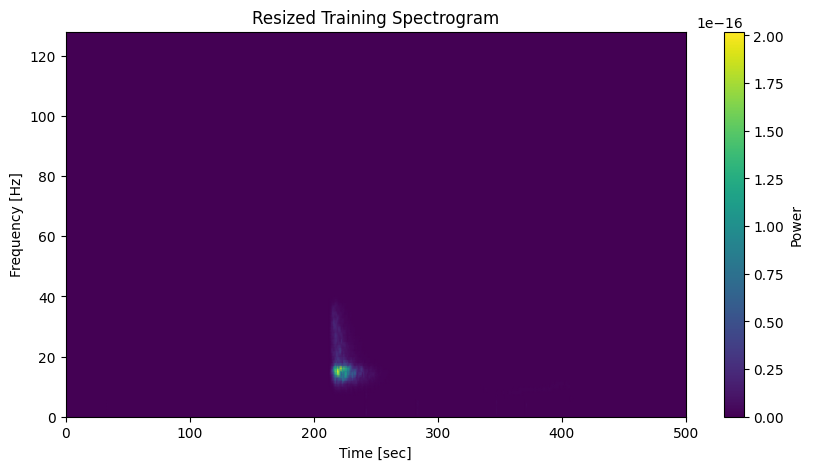

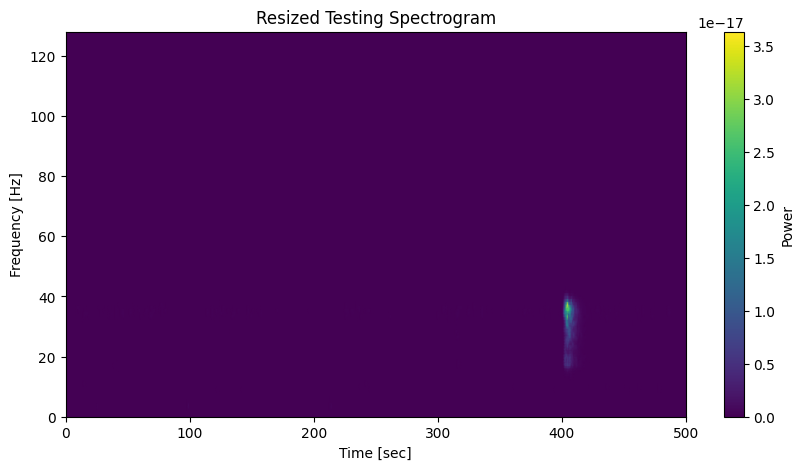

In [4]:
# Suponiendo que spectrogram_train y spectrogram_test tienen las formas correctas
n_sismos_train, freqs_train, times_train = spectrogram_train.shape
n_sismos_test, freqs_test, times_test = spectrogram_test.shape

# Definir el nuevo tamaño al que quieres reducir los espectrogramas (por ejemplo, 64x64)
new_freqs = 128
new_times = 500

# Crear una lista para almacenar los espectrogramas redimensionados del conjunto de entrenamiento
spectrograms_resized_train = []

# Redimensionar cada espectrograma del conjunto de entrenamiento
for i in range(n_sismos_train):
    resized_sxx = resize(spectrogram_train[i], (new_freqs, new_times), mode='reflect', anti_aliasing=True)
    spectrograms_resized_train.append(resized_sxx)

# Convertir la lista en una matriz numpy
spectrograms_resized_train = np.array(spectrograms_resized_train)

# Crear una lista para almacenar los espectrogramas redimensionados del conjunto de prueba
spectrograms_resized_test = []

# Redimensionar cada espectrograma del conjunto de prueba
for i in range(n_sismos_test):
    resized_sxx = resize(spectrogram_test[i], (new_freqs, new_times), mode='reflect', anti_aliasing=True)
    spectrograms_resized_test.append(resized_sxx)

# Convertir la lista en una matriz numpy
spectrograms_resized_test = np.array(spectrograms_resized_test)

# Verificar las formas de los espectrogramas redimensionados
print("Shape of Resized Training Spectrograms:", spectrograms_resized_train.shape)
print("Shape of Resized Testing Spectrograms:", spectrograms_resized_test.shape)

# Visualizar un espectrograma redimensionado del conjunto de entrenamiento
plt.figure(figsize=(10, 5))
plt.pcolormesh(np.linspace(0, new_times, new_times), np.linspace(0, new_freqs, new_freqs), spectrograms_resized_train[20], shading='gouraud')
plt.title('Resized Training Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power')
plt.show()

# Visualizar un espectrograma redimensionado del conjunto de prueba
plt.figure(figsize=(10, 5))
plt.pcolormesh(np.linspace(0, new_times, new_times), np.linspace(0, new_freqs, new_freqs), spectrograms_resized_test[5], shading='gouraud')
plt.title('Resized Testing Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power')
plt.show()


In [5]:
# Definir el modelo CNN
model = tf.keras.models.Sequential([
    # Primera capa convolucional
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(new_freqs, new_times, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Segunda capa convolucional
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Tercera capa convolucional
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Aplanar las características para pasarlas a una capa densa
    tf.keras.layers.Flatten(),

    # Capa densa completamente conectada
    tf.keras.layers.Dense(128, activation='relu'),

    # Capa de salida
    tf.keras.layers.Dense(1, activation='linear')  # Salida con una sola neurona para la predicción del valor final (regresión)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Resumen del modelo
model.summary()


c:\Users\angel\anaconda3\envs\NASA\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 498, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 249, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 247, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 123, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 121, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107520)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,762,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,855,489 (52.85 MB)

 Trainable params: 13,855,489 (52.85 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Normalizar los espectrogramas a un rango [0, 1]
spectrograms_resized_train = (spectrograms_resized_train - np.min(spectrograms_resized_train)) / (np.max(spectrograms_resized_train) - np.min(spectrograms_resized_train))
# Normalizar las etiquetas a un rango [0, 1]
max_y = np.max(ytrn)  # Debes tener los valores originales para esto
min_y = np.min(ytrn)
ytrn = (ytrn - np.min(ytrn)) / (np.max(ytrn) - np.min(ytrn))

# Asegurarse de que los espectrogramas tengan la forma (n_sismos, 64, 64, 1)
X = spectrograms_resized_train[..., np.newaxis]

# Entrenar el modelo
model.fit(X, ytrn, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 972ms/step - loss: 0.2656 - mean_absolute_error: 0.4321 - val_loss: 0.1650 - val_mean_absolute_error: 0.3490
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 896ms/step - loss: 0.1150 - mean_absolute_error: 0.2677 - val_loss: 0.1073 - val_mean_absolute_error: 0.2565
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 859ms/step - loss: 0.0956 - mean_absolute_error: 0.2680 - val_loss: 0.1169 - val_mean_absolute_error: 0.3032
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 828ms/step - loss: 0.1127 - mean_absolute_error: 0.2883 - val_loss: 0.0898 - val_mean_absolute_error: 0.2441
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 857ms/step - loss: 0.1035 - mean_absolute_error: 0.2793 - val_loss: 0.0836 - val_mean_absolute_error: 0.2503
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 836ms/step - loss: 0.0873 - mean_absolute_error: 0.2552 - val_loss: 0.0826 - val_mean_absolute_error: 0.2451
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 852ms/step - loss: 0.0928 - mean_absolute_error: 0.2720 - val_loss: 0.082

In [7]:
n_samples_test = spectrograms_resized_test.shape[0]
spectrograms_resized_test = (spectrograms_resized_test - np.min(spectrograms_resized_test)) / (np.max(spectrograms_resized_test) - np.min(spectrograms_resized_test))
spectrograms_input = spectrograms_resized_test.reshape(n_samples_test, new_freqs, new_times, 1)

# 2. Realizar las predicciones
predictions = model.predict(spectrograms_input)
predictions_original = predictions * (max_y - min_y) + min_y

# 3. Ver las predicciones
print("Predictions:", predictions_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Predictions: [[37634.043]
 [37625.117]
 [37632.703]
 [37695.086]
 [37634.934]
 [37656.92 ]
 [37626.395]
 [37623.26 ]
 [37626.1  ]
 [37624.82 ]
 [37625.82 ]
 [37725.277]
 [37624.74 ]
 [38516.402]]


In [ ]:
i = 0  # Índice del espectrograma que quieres visualizar
time_to_mark = predictions_original[0]

# Graficar velocidades en función del tiempo
plt.figure(figsize=(10, 3))
plt.plot(range(len(xtst[i, :])), xtst[i, :], label='Velocity')
plt.axvline(x=time_to_mark*len(xtst[i, :]), color='red', linestyle='--', label=f'Detection t={time_to_mark * len(xtst[i, :])} sec')
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m/s]')
plt.title('Seismic')
plt.grid(True)
plt.legend()
plt.show()

# Visualizar un espectrograma redimensionado del conjunto de prueba con su etiqueta
plt.figure(figsize=(10, 5))
plt.pcolormesh(np.linspace(0, new_times, new_times), np.linspace(0, new_freqs, new_freqs), spectrograms_resized_test[i], shading='gouraud')
# Añadir la línea vertical roja en el tiempo especificado
plt.axvline(x=time_to_mark*500, color='red', linestyle='--')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power')
plt.show()